### Install necessary packages, might also need torch, numpy and sklearn. In Kaggle these are already pre-installed.

In [1]:
!pip install -q "mamba-ssm[causal-conv1d]" # Install mamba-ssm with causal-conv1d extras 
!pip3 install -q -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
# Kaggle has these preinstalled, but to be sure we install them again.
!pip install -q monai einops nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.9/841.9 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


### Imports and Seg-Mamba definitions.

In [2]:
# from https://github.com/ge-xing/SegMamba
# mamba_ssm (install only if missing)
import importlib, sys, subprocess
if importlib.util.find_spec("mamba_ssm") is None:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "mamba-ssm"], check=True)

from mamba_ssm import Mamba
print("Mamba loaded successfully")

import os, random, warnings, shutil, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from monai.data import PersistentDataset, DataLoader, decollate_batch, list_data_collate, Dataset
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Orientationd,
    Spacingd, CropForegroundd, SpatialPadd, DivisiblePadd,
    ScaleIntensityRangePercentilesd, AsDiscreted,
    RandCropByPosNegLabeld, RandFlipd, RandAffined, RandRotated,
    RandGaussianNoised, RandGaussianSmoothd,
    DeleteItemsd, AsDiscrete, KeepLargestConnectedComponent,
)
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss


# MODEL DEFINITIONS (FROM GITHUB OF SegMamba)
from functools import partial
from monai.networks.blocks.dynunet_block import UnetOutBlock
from monai.networks.blocks.unetr_block import UnetrBasicBlock, UnetrUpBlock

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None, None] * x + self.bias[:, None, None, None]
            return x

class MambaLayer(nn.Module):
    def __init__(self, dim, d_state=16, d_conv=4, expand=2, num_slices=None):
        super().__init__()
        self.dim = dim
        self.norm = nn.LayerNorm(dim)
        self.mamba = Mamba(
            d_model=dim,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
        )

    def forward(self, x):
        B, C = x.shape[:2]
        x_skip = x
        assert C == self.dim
        n_tokens = x.shape[2:].numel()
        img_dims = x.shape[2:]
        x_flat = x.reshape(B, C, n_tokens).transpose(-1, -2)
        x_norm = self.norm(x_flat)
        x_mamba = self.mamba(x_norm)
        out = x_mamba.transpose(-1, -2).reshape(B, C, *img_dims)
        out = out + x_skip
        return out

class MlpChannel(nn.Module):
    def __init__(self, hidden_size, mlp_dim):
        super().__init__()
        self.fc1 = nn.Conv3d(hidden_size, mlp_dim, 1)
        self.act = nn.GELU()
        self.fc2 = nn.Conv3d(mlp_dim, hidden_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class GSC(nn.Module):
    def __init__(self, in_channles) -> None:
        super().__init__()
        self.proj = nn.Conv3d(in_channles, in_channles, 3, 1, 1)
        self.norm = nn.InstanceNorm3d(in_channles)
        self.nonliner = nn.ReLU()

        self.proj2 = nn.Conv3d(in_channles, in_channles, 3, 1, 1)
        self.norm2 = nn.InstanceNorm3d(in_channles)
        self.nonliner2 = nn.ReLU()

        self.proj3 = nn.Conv3d(in_channles, in_channles, 1, 1, 0)
        self.norm3 = nn.InstanceNorm3d(in_channles)
        self.nonliner3 = nn.ReLU()

        self.proj4 = nn.Conv3d(in_channles, in_channles, 1, 1, 0)
        self.norm4 = nn.InstanceNorm3d(in_channles)
        self.nonliner4 = nn.ReLU()

    def forward(self, x):
        x_residual = x

        x1 = self.proj(x)
        x1 = self.norm(x1)
        x1 = self.nonliner(x1)

        x1 = self.proj2(x1)
        x1 = self.norm2(x1)
        x1 = self.nonliner2(x1)

        x2 = self.proj3(x)
        x2 = self.norm3(x2)
        x2 = self.nonliner3(x2)

        x = x1 + x2
        x = self.proj4(x)
        x = self.norm4(x)
        x = self.nonliner4(x)

        return x + x_residual

class MambaEncoder(nn.Module):
    def __init__(self, in_chans=1, depths=[2, 2, 2, 2], dims=[48, 96, 192, 384],
                 drop_path_rate=0., layer_scale_init_value=1e-6, out_indices=[0, 1, 2, 3]):
        super().__init__()

        self.downsample_layers = nn.ModuleList()
        stem = nn.Sequential(
            nn.Conv3d(in_chans, dims[0], kernel_size=7, stride=2, padding=3),
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                nn.InstanceNorm3d(dims[i]),
                nn.Conv3d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList()
        self.gscs = nn.ModuleList()
        num_slices_list = [64, 32, 16, 8]
        for i in range(4):
            gsc = GSC(dims[i])
            stage = nn.Sequential(
                *[MambaLayer(dim=dims[i], num_slices=num_slices_list[i]) for _ in range(depths[i])]
            )
            self.stages.append(stage)
            self.gscs.append(gsc)

        self.out_indices = out_indices

        self.mlps = nn.ModuleList()
        for i_layer in range(4):
            layer = nn.InstanceNorm3d(dims[i_layer])
            layer_name = f"norm{i_layer}"
            self.add_module(layer_name, layer)
            self.mlps.append(MlpChannel(dims[i_layer], 2 * dims[i_layer]))

    def forward_features(self, x):
        outs = []
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.gscs[i](x)
            x = self.stages[i](x)

            if i in self.out_indices:
                norm_layer = getattr(self, f"norm{i}")
                x_out = norm_layer(x)
                x_out = self.mlps[i](x_out)
                outs.append(x_out)
        return tuple(outs)

    def forward(self, x):
        return self.forward_features(x)

class SegMamba(nn.Module):
    def __init__(
        self,
        in_chans=1,
        out_chans=1,
        depths=[2, 2, 2, 2],
        feat_size=[48, 96, 192, 384],
        drop_path_rate=0,
        layer_scale_init_value=1e-6,
        hidden_size: int = 768,
        norm_name="instance",
        conv_block: bool = True,
        res_block: bool = True,
        spatial_dims=3,
    ) -> None:
        super().__init__()

        self.hidden_size = hidden_size
        self.in_chans = in_chans
        self.out_chans = out_chans
        self.depths = depths
        self.drop_path_rate = drop_path_rate
        self.feat_size = feat_size
        self.layer_scale_init_value = layer_scale_init_value
        self.spatial_dims = spatial_dims

        self.vit = MambaEncoder(
            in_chans,
            depths=depths,
            dims=feat_size,
            drop_path_rate=drop_path_rate,
            layer_scale_init_value=layer_scale_init_value,
        )

        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.in_chans,
            out_channels=self.feat_size[0],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder2 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[0],
            out_channels=self.feat_size[1],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder3 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[1],
            out_channels=self.feat_size[2],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder4 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[2],
            out_channels=self.feat_size[3],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )

        self.encoder5 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[3],
            out_channels=self.hidden_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )

        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=self.hidden_size,
            out_channels=self.feat_size[3],
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[3],
            out_channels=self.feat_size[2],
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[2],
            out_channels=self.feat_size[1],
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[1],
            out_channels=self.feat_size[0],
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[0],
            out_channels=self.feat_size[0],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.out = UnetOutBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[0],
            out_channels=self.out_chans,
        )

    def proj_feat(self, x):
        new_view = [x.size(0)] + self.proj_view_shape
        x = x.view(new_view)
        x = x.permute(self.proj_axes).contiguous()
        return x

    def forward(self, x_in):
        outs = self.vit(x_in)
        enc1 = self.encoder1(x_in)

        x2 = outs[0]
        enc2 = self.encoder2(x2)

        x3 = outs[1]
        enc3 = self.encoder3(x3)

        x4 = outs[2]
        enc4 = self.encoder4(x4)

        enc_hidden = self.encoder5(outs[3])

        dec3 = self.decoder5(enc_hidden, enc4)
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        dec0 = self.decoder2(dec1, enc1)
        out = self.decoder1(dec0)
        return self.out(out)

Mamba loaded successfully


<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2026-01-21 17:59:12.317675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769018352.486945      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769018352.532892      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769018352.952570      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769018352.952594      24 computation_placer.cc:1

### Setting up

##### Cuda environment settings and CUDA GPU check, also save the number of GPUs in NGPU variable.

In [3]:
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True,max_split_size_mb:128")
warnings.filterwarnings("ignore", message="single channel prediction")
warnings.filterwarnings("ignore", category=FutureWarning)

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NGPU = torch.cuda.device_count() if torch.cuda.is_available() else 0
print(f"CUDA: {torch.cuda.get_device_name(0) if NGPU else 'CPU'} | GPUs={NGPU}")

CUDA: Tesla T4 | GPUs=2


##### Most hyperparameters, general configuration settings, and data paths are defined in the cell below.

In [4]:
# CONFIG
CONFIG = {
    "images_dir": "/kaggle/input/imagess/volumes/",
    "labels_dir": "/kaggle/input/labels/masks/",
    "cache_dir": "/kaggle/working/cache_",
    "best_model_path": "/kaggle/working/best_segmamba.pth",
    "clear_cache": True,

    "seed": 121,
    "epochs": 120,
    "batch_size": 1,
    "accum_steps": 4,
    "val_every": 1,

    "base_lr": 2.5e-5,
    "max_lr": 4e-4,
    "weight_decay": 2e-5,
    "warmup_epochs": 20,

    "drop_rate": 0.0,

    "spacing": (2.0, 2.0, 2.0),
    "roi_size": (96, 96, 64),
    "crop_margin": 8,
    "divisible_pad": (32, 32, 16),

    "swi_batch_size": 1,
    "overlap": 0.5,
    "init_threshold": 0.5,
    "thr_sweep_every": 5,
    "thr_grid": np.linspace(0.35, 0.65, 5).tolist(),

    "dice_weight": 1.0,
    "ce_weight": 1.0,

    "patience": 30,
    "min_delta": 0.0,

    "curriculum_stages": [
        {"epoch_start": 0, "pos": 1, "neg": 0, "desc": "Foreground-only"},
        {"epoch_start": 40, "pos": 3, "neg": 1, "desc": "Mixed sampling"},
        {"epoch_start": 70, "pos": 1, "neg": 1, "desc": "Balanced"},
    ],

    "ema_decay": 0.975,
}

##### Below is the pre-processing stack where we apply spatial normalization, intensity scaling, and data augmentation to prepare 3D medical images for model training.

In [5]:
os.makedirs(CONFIG["cache_dir"], exist_ok=True)
if CONFIG["clear_cache"]:
    shutil.rmtree(os.path.join(CONFIG["cache_dir"], "train"), ignore_errors=True)
    shutil.rmtree(os.path.join(CONFIG["cache_dir"], "val"), ignore_errors=True)

random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG["seed"])


# TRANSFORMS (Config-Driven)
def get_transforms():
    base_transform = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"], dtype=torch.float32, track_meta=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=CONFIG["spacing"], mode=("bilinear", "nearest")),
        ScaleIntensityRangePercentilesd(
            keys=["image"], lower=2.0, upper=99.9, b_min=0.0, b_max=1.0, clip=True
        ),
        AsDiscreted(keys=["label"], threshold=0.5),
        CropForegroundd(keys=["image", "label"], source_key="label", margin=CONFIG["crop_margin"]),
        SpatialPadd(keys=["image", "label"], spatial_size=CONFIG["roi_size"], method="symmetric"),
        DivisiblePadd(keys=["image", "label"], k=CONFIG["divisible_pad"]),
        EnsureTyped(keys=["image", "label"], dtype=torch.float32, track_meta=False),
        DeleteItemsd(keys=["image_meta_dict", "label_meta_dict"]),
    ])

    def rand_transform(pos_num, neg_num):
        return Compose([
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=CONFIG["roi_size"],
                pos=pos_num,
                neg=neg_num,
                num_samples=4,
                allow_smaller=True,
            ),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[0]),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[1]),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[2]),
            RandRotated(
                keys=["image", "label"],
                prob=0.5,
                range_x=0.15,
                range_y=0.15,
                range_z=0.15,
                mode=("bilinear", "nearest"),
                padding_mode="zeros",
            ),
            RandAffined(
                keys=["image", "label"],
                prob=0.35,
                rotate_range=(0.0, 0.0, np.pi / 6),
                scale_range=(0.2, 0.2, 0.2),
                mode=("bilinear", "nearest"),
            ),
            RandGaussianNoised(keys=["image"], prob=0.2, mean=0.0, std=0.02),
            RandGaussianSmoothd(
                keys=["image"], prob=0.2,
                sigma_x=(0.5, 1.0), sigma_y=(0.5, 1.0), sigma_z=(0.5, 1.0)
            ),
            EnsureTyped(keys=["image", "label"], dtype=torch.float32, track_meta=False),
        ])

    return base_transform, rand_transform

base_transform, rand_transform = get_transforms()

##### Then we prepare the dataset and dataloaders, implementing custom dataset loading with train/validation splitting and applying cached base transforms before random augmentations during training.

In [6]:
class PlacentaDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, limit=None):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        self.transform = transform

        image_files = sorted([f for f in self.images_dir.glob("*.nii*")])
        label_files = sorted([f for f in self.labels_dir.glob("*.nii*")])

        label_map = {f.stem.replace("_mask", ""): f for f in label_files}

        self.pairs = []
        missing = []
        for img_path in image_files:
            stem = img_path.stem
            lbl_path = label_map.get(stem)
            if lbl_path is None or not lbl_path.exists():
                missing.append(img_path.name)
                continue
            self.pairs.append({"image": str(img_path), "label": str(lbl_path)})

        if limit is not None:
            self.pairs = self.pairs[:limit]

        if missing:
            print(f"[Dataset] WARNING: {len(missing)} images missing labels (showing first 3): {missing[:3]}")
        print(f"[Dataset] Loaded {len(self.pairs)} valid image-label pairs")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        sample = dict(self.pairs[idx])
        return self.transform(sample) if self.transform else sample

full_dataset = PlacentaDataset(CONFIG["images_dir"], CONFIG["labels_dir"], transform=None)

all_indices = np.arange(len(full_dataset))
train_idx, val_idx = train_test_split(all_indices, test_size=0.2, random_state=CONFIG["seed"])
train_items = [full_dataset.pairs[i] for i in train_idx]
val_items = [full_dataset.pairs[i] for i in val_idx]
print(f"[Split] Train: {len(train_items)} | Val: {len(val_items)}")

train_cache = PersistentDataset(train_items, transform=base_transform, cache_dir=os.path.join(CONFIG["cache_dir"], "train"))
val_cache   = PersistentDataset(val_items,   transform=base_transform, cache_dir=os.path.join(CONFIG["cache_dir"], "val"))

train_dataset = Dataset(train_cache, transform=rand_transform(1, 0))
val_dataset   = Dataset(val_cache,   transform=EnsureTyped(keys=["image", "label"], dtype=torch.float32, track_meta=False))

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=4,
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory=True,
    collate_fn=list_data_collate,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    persistent_workers=True,
    pin_memory=True,
    collate_fn=list_data_collate,
)

[Dataset] Loaded 137 valid image-label pairs
[Split] Train: 109 | Val: 28


##### And define the model, loss functions, optimizer and scheduler and pass them the parameters defined from the CONFIG map above.

In [7]:
model_core = SegMamba(
    in_chans=1,
    out_chans=1,
    feat_size=[32, 64, 128, 256],
    depths=[2, 2, 2, 2],
    hidden_size=1536,
    drop_path_rate=CONFIG["drop_rate"],
).to(device)

try:
    model_core = model_core.to(memory_format=torch.channels_last_3d)
except Exception:
    pass

model = model_core
print("Model: SegMamba (single GPU/CPU)")


# LOSS / OPT / SCHED / EMA

criterion = DiceCELoss(
    include_background=False,
    to_onehot_y=False,
    sigmoid=True,
    squared_pred=True,
    lambda_dice=CONFIG["dice_weight"],
    lambda_ce=CONFIG["ce_weight"],
)

dice_only_loss = DiceCELoss(include_background=False, to_onehot_y=False, sigmoid=True, squared_pred=True, lambda_dice=1.0, lambda_ce=0.0)
ce_only_loss   = DiceCELoss(include_background=False, to_onehot_y=False, sigmoid=True, squared_pred=True, lambda_dice=0.0, lambda_ce=1.0)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG["base_lr"],
    weight_decay=CONFIG["weight_decay"],
    betas=(0.9, 0.999),
)

def compute_opt_steps_per_epoch(dloader_len, accum_steps):
    return max(1, math.ceil(dloader_len / max(1, accum_steps)))

opt_steps_per_epoch = compute_opt_steps_per_epoch(len(train_loader), CONFIG["accum_steps"])
cycle_epochs = 4

scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=CONFIG["base_lr"],
    max_lr=CONFIG["max_lr"],
    step_size_up=opt_steps_per_epoch * (cycle_epochs // 2),
    step_size_down=opt_steps_per_epoch * (cycle_epochs // 2),
    mode="triangular",
    cycle_momentum=True,
)

Model: SegMamba (single GPU/CPU)


##### Validation with EMA and some custom helper functions.

In [8]:
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {k: p.detach().clone() for k, p in model.named_parameters() if p.requires_grad}
        self.backup = None

    @torch.no_grad()
    def update(self, model):
        for k, p in model.named_parameters():
            if not p.requires_grad:
                continue
            self.shadow[k].mul_(self.decay).add_(p.detach(), alpha=1 - self.decay)

    @torch.no_grad()
    def apply(self, model):
        self.backup = {k: p.detach().clone() for k, p in model.named_parameters() if p.requires_grad}
        for k, p in model.named_parameters():
            if not p.requires_grad:
                continue
            p.data.copy_(self.shadow[k])

    @torch.no_grad()
    def restore(self, model):
        for k, p in model.named_parameters():
            if not p.requires_grad:
                continue
            p.data.copy_(self.backup[k])

ema = EMA(model, decay=CONFIG["ema_decay"])
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

post_label = AsDiscrete(threshold=0.5)
keep_lcc = KeepLargestConnectedComponent(connectivity=3, num_components=1)

@torch.no_grad()
def postprocess_mask(bin_pred: torch.Tensor, min_size=500):
    x = keep_lcc(bin_pred)
    if x.sum() > 0 and min_size > 0:
        _ = torch.unique(x)  # kept as-is (no-op filter)
    return x

@torch.no_grad()
def dice_score(y_pred_bin: torch.Tensor, y_true_bin: torch.Tensor):
    inter = (y_pred_bin * y_true_bin).sum()
    union = y_pred_bin.sum() + y_true_bin.sum()
    return float((2.0 * inter + 1e-7) / (union + 1e-7))

@torch.no_grad()
def validate_model(model, loader, threshold=0.5, do_threshold_sweep=False, calc_components=False):
    model.eval()
    dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)
    dice_metric.reset()

    total_loss = 0.0
    total_dice_loss = 0.0
    total_ce_loss = 0.0
    iou_sum = 0.0
    n_cases = 0

    thr_grid = CONFIG["thr_grid"] if do_threshold_sweep else []
    sweep_scores = np.zeros(len(thr_grid))

    pbar = tqdm(loader, desc="Validation", leave=False)
    for batch in pbar:
        x = batch["image"].to(device, non_blocking=True).float()
        y = batch["label"].to(device, non_blocking=True).float()

        try:
            x = x.to(memory_format=torch.channels_last_3d)
            y = y.to(memory_format=torch.channels_last_3d)
        except Exception:
            pass

        sw_bs = int(CONFIG["swi_batch_size"])
        logits = None
        while sw_bs >= 1:
            try:
                with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                    logits = sliding_window_inference(
                        x,
                        roi_size=CONFIG["roi_size"],
                        sw_batch_size=sw_bs,
                        predictor=model,
                        overlap=CONFIG["overlap"],
                        mode="gaussian",
                    )
                break
            except torch.cuda.OutOfMemoryError:
                torch.cuda.empty_cache()
                sw_bs //= 2
                if sw_bs < 1:
                    print(f"[OOM] Skipping batch at size {x.shape} - cannot process")
                    break

        if logits is None:
            continue

        loss = criterion(logits, y)
        total_loss += float(loss)

        if calc_components:
            total_dice_loss += float(dice_only_loss(logits, y))
            total_ce_loss += float(ce_only_loss(logits, y))

        probs = torch.sigmoid(logits)
        preds_bin = (probs >= threshold).float()

        preds_list = decollate_batch(preds_bin)
        trues_list = decollate_batch(y > 0.5)

        preds_pp = [postprocess_mask(p) for p in preds_list]
        dice_metric(y_pred=preds_pp, y=trues_list)

        for p, t in zip(preds_pp, trues_list):
            inter = (p * t).sum()
            union = (p + t).sum()
            iou_sum += float((inter + 1e-7) / (union - inter + 1e-7))

        if do_threshold_sweep:
            y_bin_list = decollate_batch((y > 0.5).float())
            prob_list = decollate_batch(probs)
            for i, thr in enumerate(thr_grid):
                sweep_preds = [(prob_i >= float(thr)).float() for prob_i in prob_list]
                sweep_pp = [postprocess_mask(p_i) for p_i in sweep_preds]
                sweep_scores[i] += np.mean([dice_score(p_i, t_i) for p_i, t_i in zip(sweep_pp, y_bin_list)])

        n_cases += 1
        if n_cases % 10 == 0:
            torch.cuda.empty_cache()
        pbar.set_postfix({"cases": n_cases})

    avg_loss = total_loss / max(n_cases, 1)
    avg_dice_loss = total_dice_loss / max(n_cases, 1) if calc_components else float("nan")
    avg_ce_loss = total_ce_loss / max(n_cases, 1) if calc_components else float("nan")
    avg_dice = dice_metric.aggregate().item()
    avg_iou = iou_sum / max(n_cases, 1)

    best_thr, best_dice_sweep = None, None
    if do_threshold_sweep and n_cases > 0:
        sweep_scores /= n_cases
        best_idx = int(np.argmax(sweep_scores))
        best_thr = float(thr_grid[best_idx])
        best_dice_sweep = float(sweep_scores[best_idx])

    torch.cuda.empty_cache()
    return avg_loss, avg_dice_loss, avg_ce_loss, avg_dice, avg_iou, best_thr, best_dice_sweep

### Training and Validation

##### Training and validation loop, and finally printing the graphs of the dice score, training/validation loss and threshold + learning rate throughout the 120 epochs.

Starting Training...

[Curriculum] Epoch 1: Foreground-only (pos=1, neg=0)
[Memory] Before training: 0.77 GB allocated


Epoch 1/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

/tmp/ipykernel_24/3050994033.py:70: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  pbar_train.set_postfix({"loss": f"{float(loss):.4f}"})


Validation:   0%|          | 0/28 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:231: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:347.)
  win_data = inputs[unravel_slice[0]].to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:347.)
  out[idx_zm] += p


[Epoch 001] TrainLoss: 1.0743 | ValLoss: 1.1261 | ValDice@thr0.50: 0.4458 | ValIoU: 0.2899 | LR: 2.13e-04 | **NEW BEST**


Epoch 2/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 002] TrainLoss: 0.6901 | ValLoss: 0.7130 | ValDice@thr0.50: 0.6237 | ValIoU: 0.4591 | LR: 4.00e-04 | **NEW BEST**


Epoch 3/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 003] TrainLoss: 0.5827 | ValLoss: 0.5796 | ValDice@thr0.50: 0.6643 | ValIoU: 0.5038 | LR: 2.13e-04 | **NEW BEST**


Epoch 4/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 004] TrainLoss: 0.5246 | ValLoss: 0.5063 | ValDice@thr0.50: 0.6960 | ValIoU: 0.5405 | LR: 2.50e-05 | **NEW BEST**


Epoch 5/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 005] TrainLoss: 0.4955 | ValLoss: 0.4634 | ValDice@thr0.57: 0.7156 | ValIoU: 0.5638 | LR: 2.13e-04 | thr 0.500→0.575 | **NEW BEST**


Epoch 6/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 006] TrainLoss: 0.4998 | ValLoss: 0.4345 | ValDice@thr0.57: 0.7281 | ValIoU: 0.5789 | LR: 4.00e-04 | **NEW BEST**


Epoch 7/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 007] TrainLoss: 0.4919 | ValLoss: 0.4156 | ValDice@thr0.57: 0.7300 | ValIoU: 0.5833 | LR: 2.13e-04 | **NEW BEST**


Epoch 8/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 008] TrainLoss: 0.4511 | ValLoss: 0.3930 | ValDice@thr0.57: 0.7353 | ValIoU: 0.5899 | LR: 2.50e-05 | **NEW BEST**


Epoch 9/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 009] TrainLoss: 0.4170 | ValLoss: 0.3768 | ValDice@thr0.57: 0.7423 | ValIoU: 0.5979 | LR: 2.13e-04 | **NEW BEST**


Epoch 10/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 010] TrainLoss: 0.4256 | ValLoss: 0.3591 | ValDice@thr0.57: 0.7537 | ValIoU: 0.6119 | LR: 4.00e-04 | **NEW BEST**


Epoch 11/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 011] TrainLoss: 0.4254 | ValLoss: 0.3488 | ValDice@thr0.57: 0.7571 | ValIoU: 0.6154 | LR: 2.13e-04 | **NEW BEST**


Epoch 12/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 012] TrainLoss: 0.4065 | ValLoss: 0.3357 | ValDice@thr0.57: 0.7629 | ValIoU: 0.6221 | LR: 2.50e-05 | **NEW BEST**


Epoch 13/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 013] TrainLoss: 0.3699 | ValLoss: 0.3253 | ValDice@thr0.57: 0.7658 | ValIoU: 0.6261 | LR: 2.13e-04 | **NEW BEST**


Epoch 14/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 014] TrainLoss: 0.3983 | ValLoss: 0.3155 | ValDice@thr0.57: 0.7699 | ValIoU: 0.6315 | LR: 4.00e-04 | **NEW BEST**


Epoch 15/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 015] TrainLoss: 0.3880 | ValLoss: 0.3115 | ValDice@thr0.57: 0.7699 | ValIoU: 0.6320 | LR: 2.13e-04 


Epoch 16/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 016] TrainLoss: 0.3592 | ValLoss: 0.3009 | ValDice@thr0.57: 0.7776 | ValIoU: 0.6417 | LR: 2.50e-05 | **NEW BEST**


Epoch 17/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 017] TrainLoss: 0.3406 | ValLoss: 0.2932 | ValDice@thr0.57: 0.7811 | ValIoU: 0.6461 | LR: 2.13e-04 | **NEW BEST**


Epoch 18/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 018] TrainLoss: 0.3591 | ValLoss: 0.2876 | ValDice@thr0.57: 0.7851 | ValIoU: 0.6510 | LR: 4.00e-04 | **NEW BEST**


Epoch 19/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 019] TrainLoss: 0.3706 | ValLoss: 0.2931 | ValDice@thr0.57: 0.7799 | ValIoU: 0.6453 | LR: 2.13e-04 


Epoch 20/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 020] TrainLoss: 0.3306 | ValLoss: 0.2904 | ValDice@thr0.57: 0.7797 | ValIoU: 0.6463 | LR: 2.50e-05 


Epoch 21/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 021] TrainLoss: 0.3193 | ValLoss: 0.2836 | ValDice@thr0.57: 0.7827 | ValIoU: 0.6496 | LR: 2.13e-04 


Epoch 22/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 022] TrainLoss: 0.3320 | ValLoss: 0.2778 | ValDice@thr0.57: 0.7855 | ValIoU: 0.6528 | LR: 4.00e-04 | **NEW BEST**


Epoch 23/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 023] TrainLoss: 0.3553 | ValLoss: 0.2694 | ValDice@thr0.57: 0.7895 | ValIoU: 0.6575 | LR: 2.13e-04 | **NEW BEST**


Epoch 24/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 024] TrainLoss: 0.3206 | ValLoss: 0.2632 | ValDice@thr0.57: 0.7929 | ValIoU: 0.6611 | LR: 2.50e-05 | **NEW BEST**


Epoch 25/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 025] TrainLoss: 0.2981 | ValLoss: 0.2602 | ValDice@thr0.50: 0.7950 | ValIoU: 0.6642 | LR: 2.13e-04 | thr 0.575→0.500 | **NEW BEST**


Epoch 26/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 026] TrainLoss: 0.3120 | ValLoss: 0.2559 | ValDice@thr0.50: 0.7994 | ValIoU: 0.6700 | LR: 4.00e-04 | **NEW BEST**


Epoch 27/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 027] TrainLoss: 0.3223 | ValLoss: 0.2557 | ValDice@thr0.50: 0.8006 | ValIoU: 0.6715 | LR: 2.13e-04 | **NEW BEST**


Epoch 28/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 028] TrainLoss: 0.2980 | ValLoss: 0.2466 | ValDice@thr0.50: 0.8068 | ValIoU: 0.6791 | LR: 2.50e-05 | **NEW BEST**


Epoch 29/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 029] TrainLoss: 0.2790 | ValLoss: 0.2409 | ValDice@thr0.50: 0.8102 | ValIoU: 0.6836 | LR: 2.13e-04 | **NEW BEST**


Epoch 30/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 030] TrainLoss: 0.3020 | ValLoss: 0.2399 | ValDice@thr0.50: 0.8098 | ValIoU: 0.6834 | LR: 4.00e-04 


Epoch 31/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 031] TrainLoss: 0.3203 | ValLoss: 0.2369 | ValDice@thr0.50: 0.8105 | ValIoU: 0.6846 | LR: 2.13e-04 | **NEW BEST**


Epoch 32/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 032] TrainLoss: 0.2889 | ValLoss: 0.2364 | ValDice@thr0.50: 0.8109 | ValIoU: 0.6851 | LR: 2.50e-05 | **NEW BEST**


Epoch 33/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 033] TrainLoss: 0.2791 | ValLoss: 0.2299 | ValDice@thr0.50: 0.8165 | ValIoU: 0.6930 | LR: 2.13e-04 | **NEW BEST**


Epoch 34/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 034] TrainLoss: 0.2880 | ValLoss: 0.2260 | ValDice@thr0.50: 0.8190 | ValIoU: 0.6960 | LR: 4.00e-04 | **NEW BEST**


Epoch 35/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 035] TrainLoss: 0.3077 | ValLoss: 0.2282 | ValDice@thr0.50: 0.8159 | ValIoU: 0.6919 | LR: 2.13e-04 


Epoch 36/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 036] TrainLoss: 0.2817 | ValLoss: 0.2251 | ValDice@thr0.50: 0.8187 | ValIoU: 0.6959 | LR: 2.50e-05 


Epoch 37/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 037] TrainLoss: 0.2673 | ValLoss: 0.2222 | ValDice@thr0.50: 0.8207 | ValIoU: 0.6986 | LR: 2.13e-04 | **NEW BEST**


Epoch 38/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 038] TrainLoss: 0.2752 | ValLoss: 0.2213 | ValDice@thr0.50: 0.8195 | ValIoU: 0.6969 | LR: 4.00e-04 


Epoch 39/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 039] TrainLoss: 0.2865 | ValLoss: 0.2222 | ValDice@thr0.50: 0.8195 | ValIoU: 0.6965 | LR: 2.13e-04 


Epoch 40/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 040] TrainLoss: 0.2700 | ValLoss: 0.2235 | ValDice@thr0.50: 0.8153 | ValIoU: 0.6914 | LR: 2.50e-05 

[Curriculum] Epoch 41: Mixed sampling (pos=3, neg=1)


Epoch 41/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 041] TrainLoss: 0.2561 | ValLoss: 0.2194 | ValDice@thr0.50: 0.8196 | ValIoU: 0.6972 | LR: 2.13e-04 


Epoch 42/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 042] TrainLoss: 0.2698 | ValLoss: 0.2171 | ValDice@thr0.50: 0.8237 | ValIoU: 0.7034 | LR: 4.00e-04 | **NEW BEST**


Epoch 43/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 043] TrainLoss: 0.2779 | ValLoss: 0.2168 | ValDice@thr0.50: 0.8241 | ValIoU: 0.7033 | LR: 2.13e-04 | **NEW BEST**


Epoch 44/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 044] TrainLoss: 0.2616 | ValLoss: 0.2191 | ValDice@thr0.50: 0.8213 | ValIoU: 0.6996 | LR: 2.50e-05 


Epoch 45/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 045] TrainLoss: 0.2586 | ValLoss: 0.2177 | ValDice@thr0.50: 0.8223 | ValIoU: 0.7008 | LR: 2.13e-04 


Epoch 46/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 046] TrainLoss: 0.2681 | ValLoss: 0.2184 | ValDice@thr0.50: 0.8210 | ValIoU: 0.6994 | LR: 4.00e-04 


Epoch 47/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 047] TrainLoss: 0.2745 | ValLoss: 0.2160 | ValDice@thr0.50: 0.8221 | ValIoU: 0.7010 | LR: 2.13e-04 


Epoch 48/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 048] TrainLoss: 0.2622 | ValLoss: 0.2075 | ValDice@thr0.50: 0.8300 | ValIoU: 0.7115 | LR: 2.50e-05 | **NEW BEST**


Epoch 49/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 049] TrainLoss: 0.2446 | ValLoss: 0.2071 | ValDice@thr0.50: 0.8306 | ValIoU: 0.7122 | LR: 2.13e-04 | **NEW BEST**


Epoch 50/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 050] TrainLoss: 0.2738 | ValLoss: 0.2069 | ValDice@thr0.50: 0.8315 | ValIoU: 0.7139 | LR: 4.00e-04 | **NEW BEST**


Epoch 51/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 051] TrainLoss: 0.2681 | ValLoss: 0.2097 | ValDice@thr0.50: 0.8306 | ValIoU: 0.7124 | LR: 2.13e-04 


Epoch 52/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 052] TrainLoss: 0.2466 | ValLoss: 0.2087 | ValDice@thr0.50: 0.8295 | ValIoU: 0.7108 | LR: 2.50e-05 


Epoch 53/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 053] TrainLoss: 0.2408 | ValLoss: 0.2054 | ValDice@thr0.50: 0.8322 | ValIoU: 0.7145 | LR: 2.13e-04 | **NEW BEST**


Epoch 54/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 054] TrainLoss: 0.2523 | ValLoss: 0.2047 | ValDice@thr0.50: 0.8320 | ValIoU: 0.7143 | LR: 4.00e-04 


Epoch 55/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 055] TrainLoss: 0.2591 | ValLoss: 0.2039 | ValDice@thr0.50: 0.8330 | ValIoU: 0.7161 | LR: 2.13e-04 | **NEW BEST**


Epoch 56/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 056] TrainLoss: 0.2410 | ValLoss: 0.2034 | ValDice@thr0.50: 0.8371 | ValIoU: 0.7214 | LR: 2.50e-05 | **NEW BEST**


Epoch 57/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 057] TrainLoss: 0.2350 | ValLoss: 0.2020 | ValDice@thr0.50: 0.8376 | ValIoU: 0.7222 | LR: 2.13e-04 | **NEW BEST**


Epoch 58/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 058] TrainLoss: 0.2473 | ValLoss: 0.1997 | ValDice@thr0.50: 0.8381 | ValIoU: 0.7227 | LR: 4.00e-04 | **NEW BEST**


Epoch 59/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 059] TrainLoss: 0.2611 | ValLoss: 0.1957 | ValDice@thr0.50: 0.8399 | ValIoU: 0.7254 | LR: 2.13e-04 | **NEW BEST**


Epoch 60/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 060] TrainLoss: 0.2375 | ValLoss: 0.1952 | ValDice@thr0.50: 0.8396 | ValIoU: 0.7251 | LR: 2.50e-05 


Epoch 61/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 061] TrainLoss: 0.2304 | ValLoss: 0.1936 | ValDice@thr0.50: 0.8410 | ValIoU: 0.7271 | LR: 2.13e-04 | **NEW BEST**


Epoch 62/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 062] TrainLoss: 0.2396 | ValLoss: 0.1936 | ValDice@thr0.50: 0.8410 | ValIoU: 0.7272 | LR: 4.00e-04 


Epoch 63/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 063] TrainLoss: 0.2477 | ValLoss: 0.1940 | ValDice@thr0.50: 0.8413 | ValIoU: 0.7277 | LR: 2.13e-04 | **NEW BEST**


Epoch 64/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 064] TrainLoss: 0.2373 | ValLoss: 0.1952 | ValDice@thr0.50: 0.8412 | ValIoU: 0.7275 | LR: 2.50e-05 


Epoch 65/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 065] TrainLoss: 0.2277 | ValLoss: 0.1943 | ValDice@thr0.50: 0.8418 | ValIoU: 0.7284 | LR: 2.13e-04 | **NEW BEST**


Epoch 66/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 066] TrainLoss: 0.2344 | ValLoss: 0.1913 | ValDice@thr0.50: 0.8440 | ValIoU: 0.7316 | LR: 4.00e-04 | **NEW BEST**


Epoch 67/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 067] TrainLoss: 0.2463 | ValLoss: 0.1921 | ValDice@thr0.50: 0.8420 | ValIoU: 0.7285 | LR: 2.13e-04 


Epoch 68/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 068] TrainLoss: 0.2320 | ValLoss: 0.1933 | ValDice@thr0.50: 0.8410 | ValIoU: 0.7269 | LR: 2.50e-05 


Epoch 69/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 069] TrainLoss: 0.2260 | ValLoss: 0.1930 | ValDice@thr0.50: 0.8423 | ValIoU: 0.7288 | LR: 2.13e-04 


Epoch 70/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 070] TrainLoss: 0.2320 | ValLoss: 0.1916 | ValDice@thr0.50: 0.8446 | ValIoU: 0.7323 | LR: 4.00e-04 | **NEW BEST**

[Curriculum] Epoch 71: Balanced (pos=1, neg=1)


Epoch 71/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 071] TrainLoss: 0.2519 | ValLoss: 0.1930 | ValDice@thr0.50: 0.8393 | ValIoU: 0.7253 | LR: 2.13e-04 


Epoch 72/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 072] TrainLoss: 0.2247 | ValLoss: 0.1914 | ValDice@thr0.50: 0.8439 | ValIoU: 0.7313 | LR: 2.50e-05 


Epoch 73/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 073] TrainLoss: 0.2201 | ValLoss: 0.1906 | ValDice@thr0.50: 0.8441 | ValIoU: 0.7315 | LR: 2.13e-04 


Epoch 74/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 074] TrainLoss: 0.2281 | ValLoss: 0.1909 | ValDice@thr0.50: 0.8442 | ValIoU: 0.7317 | LR: 4.00e-04 


Epoch 75/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 075] TrainLoss: 0.2334 | ValLoss: 0.1883 | ValDice@thr0.50: 0.8459 | ValIoU: 0.7342 | LR: 2.13e-04 | **NEW BEST**


Epoch 76/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 076] TrainLoss: 0.2199 | ValLoss: 0.1922 | ValDice@thr0.50: 0.8433 | ValIoU: 0.7303 | LR: 2.50e-05 


Epoch 77/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 077] TrainLoss: 0.2193 | ValLoss: 0.1912 | ValDice@thr0.50: 0.8443 | ValIoU: 0.7317 | LR: 2.13e-04 


Epoch 78/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 078] TrainLoss: 0.2232 | ValLoss: 0.1865 | ValDice@thr0.50: 0.8463 | ValIoU: 0.7348 | LR: 4.00e-04 | **NEW BEST**


Epoch 79/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 079] TrainLoss: 0.2357 | ValLoss: 0.1903 | ValDice@thr0.50: 0.8465 | ValIoU: 0.7351 | LR: 2.13e-04 | **NEW BEST**


Epoch 80/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 080] TrainLoss: 0.2293 | ValLoss: 0.1899 | ValDice@thr0.50: 0.8466 | ValIoU: 0.7354 | LR: 2.50e-05 | **NEW BEST**


Epoch 81/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 081] TrainLoss: 0.2175 | ValLoss: 0.1878 | ValDice@thr0.50: 0.8461 | ValIoU: 0.7347 | LR: 2.13e-04 


Epoch 82/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 082] TrainLoss: 0.2187 | ValLoss: 0.1862 | ValDice@thr0.50: 0.8466 | ValIoU: 0.7354 | LR: 4.00e-04 


Epoch 83/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 083] TrainLoss: 0.2339 | ValLoss: 0.1869 | ValDice@thr0.50: 0.8471 | ValIoU: 0.7360 | LR: 2.13e-04 | **NEW BEST**


Epoch 84/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 084] TrainLoss: 0.2213 | ValLoss: 0.1871 | ValDice@thr0.50: 0.8476 | ValIoU: 0.7367 | LR: 2.50e-05 | **NEW BEST**


Epoch 85/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 085] TrainLoss: 0.2175 | ValLoss: 0.1861 | ValDice@thr0.50: 0.8491 | ValIoU: 0.7390 | LR: 2.13e-04 | **NEW BEST**


Epoch 86/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 086] TrainLoss: 0.2210 | ValLoss: 0.1849 | ValDice@thr0.50: 0.8495 | ValIoU: 0.7396 | LR: 4.00e-04 | **NEW BEST**


Epoch 87/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 087] TrainLoss: 0.2281 | ValLoss: 0.1845 | ValDice@thr0.50: 0.8493 | ValIoU: 0.7395 | LR: 2.13e-04 


Epoch 88/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 088] TrainLoss: 0.2165 | ValLoss: 0.1849 | ValDice@thr0.50: 0.8490 | ValIoU: 0.7390 | LR: 2.50e-05 


Epoch 89/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 089] TrainLoss: 0.2055 | ValLoss: 0.1835 | ValDice@thr0.50: 0.8494 | ValIoU: 0.7395 | LR: 2.13e-04 


Epoch 90/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 090] TrainLoss: 0.2173 | ValLoss: 0.1866 | ValDice@thr0.50: 0.8483 | ValIoU: 0.7379 | LR: 4.00e-04 


Epoch 91/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 091] TrainLoss: 0.2314 | ValLoss: 0.1878 | ValDice@thr0.50: 0.8481 | ValIoU: 0.7377 | LR: 2.13e-04 


Epoch 92/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 092] TrainLoss: 0.2119 | ValLoss: 0.1877 | ValDice@thr0.50: 0.8482 | ValIoU: 0.7379 | LR: 2.50e-05 


Epoch 93/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 093] TrainLoss: 0.2096 | ValLoss: 0.1866 | ValDice@thr0.50: 0.8486 | ValIoU: 0.7384 | LR: 2.13e-04 


Epoch 94/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 094] TrainLoss: 0.2171 | ValLoss: 0.1849 | ValDice@thr0.50: 0.8499 | ValIoU: 0.7403 | LR: 4.00e-04 | **NEW BEST**


Epoch 95/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 095] TrainLoss: 0.2259 | ValLoss: 0.1853 | ValDice@thr0.50: 0.8490 | ValIoU: 0.7393 | LR: 2.13e-04 


Epoch 96/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 096] TrainLoss: 0.2111 | ValLoss: 0.1826 | ValDice@thr0.50: 0.8506 | ValIoU: 0.7415 | LR: 2.50e-05 | **NEW BEST**


Epoch 97/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 097] TrainLoss: 0.2046 | ValLoss: 0.1818 | ValDice@thr0.50: 0.8503 | ValIoU: 0.7409 | LR: 2.13e-04 


Epoch 98/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 098] TrainLoss: 0.2101 | ValLoss: 0.1814 | ValDice@thr0.50: 0.8513 | ValIoU: 0.7423 | LR: 4.00e-04 | **NEW BEST**


Epoch 99/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 099] TrainLoss: 0.2339 | ValLoss: 0.1811 | ValDice@thr0.50: 0.8521 | ValIoU: 0.7436 | LR: 2.13e-04 | **NEW BEST**


Epoch 100/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 100] TrainLoss: 0.2104 | ValLoss: 0.1840 | ValDice@thr0.50: 0.8503 | ValIoU: 0.7408 | LR: 2.50e-05 


Epoch 101/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 101] TrainLoss: 0.2022 | ValLoss: 0.1851 | ValDice@thr0.50: 0.8502 | ValIoU: 0.7407 | LR: 2.13e-04 


Epoch 102/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 102] TrainLoss: 0.2156 | ValLoss: 0.1855 | ValDice@thr0.50: 0.8494 | ValIoU: 0.7396 | LR: 4.00e-04 
          └─ Loss Components - Dice: 0.1242, CE: 0.0613


Epoch 103/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 103] TrainLoss: 0.2204 | ValLoss: 0.1814 | ValDice@thr0.50: 0.8528 | ValIoU: 0.7445 | LR: 2.13e-04 | **NEW BEST**
          └─ Loss Components - Dice: 0.1214, CE: 0.0600


Epoch 104/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 104] TrainLoss: 0.2093 | ValLoss: 0.1817 | ValDice@thr0.50: 0.8528 | ValIoU: 0.7445 | LR: 2.50e-05 | **NEW BEST**
          └─ Loss Components - Dice: 0.1217, CE: 0.0600


Epoch 105/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 105] TrainLoss: 0.1983 | ValLoss: 0.1819 | ValDice@thr0.50: 0.8528 | ValIoU: 0.7445 | LR: 2.13e-04 | **NEW BEST**
          └─ Loss Components - Dice: 0.1217, CE: 0.0601


Epoch 106/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 106] TrainLoss: 0.2083 | ValLoss: 0.1872 | ValDice@thr0.50: 0.8483 | ValIoU: 0.7382 | LR: 4.00e-04 
          └─ Loss Components - Dice: 0.1254, CE: 0.0618


Epoch 107/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 107] TrainLoss: 0.2244 | ValLoss: 0.1884 | ValDice@thr0.50: 0.8489 | ValIoU: 0.7388 | LR: 2.13e-04 
          └─ Loss Components - Dice: 0.1261, CE: 0.0623


Epoch 108/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 108] TrainLoss: 0.2070 | ValLoss: 0.1960 | ValDice@thr0.50: 0.8432 | ValIoU: 0.7315 | LR: 2.50e-05 
          └─ Loss Components - Dice: 0.1310, CE: 0.0651


Epoch 109/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 109] TrainLoss: 0.1998 | ValLoss: 0.1929 | ValDice@thr0.50: 0.8449 | ValIoU: 0.7337 | LR: 2.13e-04 
          └─ Loss Components - Dice: 0.1291, CE: 0.0638


Epoch 110/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 110] TrainLoss: 0.2032 | ValLoss: 0.1945 | ValDice@thr0.50: 0.8440 | ValIoU: 0.7330 | LR: 4.00e-04 
          └─ Loss Components - Dice: 0.1302, CE: 0.0643


Epoch 111/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 111] TrainLoss: 0.2168 | ValLoss: 0.1865 | ValDice@thr0.50: 0.8503 | ValIoU: 0.7409 | LR: 2.13e-04 
          └─ Loss Components - Dice: 0.1247, CE: 0.0618


Epoch 112/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 112] TrainLoss: 0.2048 | ValLoss: 0.1854 | ValDice@thr0.50: 0.8506 | ValIoU: 0.7413 | LR: 2.50e-05 
          └─ Loss Components - Dice: 0.1239, CE: 0.0615


Epoch 113/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 113] TrainLoss: 0.1962 | ValLoss: 0.1843 | ValDice@thr0.50: 0.8511 | ValIoU: 0.7422 | LR: 2.13e-04 
          └─ Loss Components - Dice: 0.1232, CE: 0.0612


Epoch 114/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 114] TrainLoss: 0.2052 | ValLoss: 0.1821 | ValDice@thr0.50: 0.8525 | ValIoU: 0.7442 | LR: 4.00e-04 
          └─ Loss Components - Dice: 0.1218, CE: 0.0603


Epoch 115/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 115] TrainLoss: 0.2216 | ValLoss: 0.1828 | ValDice@thr0.50: 0.8522 | ValIoU: 0.7436 | LR: 2.13e-04 
          └─ Loss Components - Dice: 0.1224, CE: 0.0604


Epoch 116/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 116] TrainLoss: 0.2045 | ValLoss: 0.1822 | ValDice@thr0.50: 0.8523 | ValIoU: 0.7439 | LR: 2.50e-05 
          └─ Loss Components - Dice: 0.1219, CE: 0.0603


Epoch 117/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 117] TrainLoss: 0.2010 | ValLoss: 0.1797 | ValDice@thr0.50: 0.8517 | ValIoU: 0.7431 | LR: 2.13e-04 
          └─ Loss Components - Dice: 0.1202, CE: 0.0595


Epoch 118/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 118] TrainLoss: 0.2066 | ValLoss: 0.1790 | ValDice@thr0.50: 0.8532 | ValIoU: 0.7453 | LR: 4.00e-04 | **NEW BEST**
          └─ Loss Components - Dice: 0.1198, CE: 0.0592


Epoch 119/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 119] TrainLoss: 0.2117 | ValLoss: 0.1786 | ValDice@thr0.50: 0.8536 | ValIoU: 0.7459 | LR: 2.13e-04 | **NEW BEST**
          └─ Loss Components - Dice: 0.1197, CE: 0.0589


Epoch 120/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 120] TrainLoss: 0.1992 | ValLoss: 0.1781 | ValDice@thr0.50: 0.8538 | ValIoU: 0.7462 | LR: 2.50e-05 | **NEW BEST**
          └─ Loss Components - Dice: 0.1193, CE: 0.0588

Training Complete!
Best Validation Dice: 0.8538 @ Epoch 120
Best Model Saved: /kaggle/working/best_segmamba.pth
Final Threshold: 0.500

Generating plots...
Plot saved: training_history.png


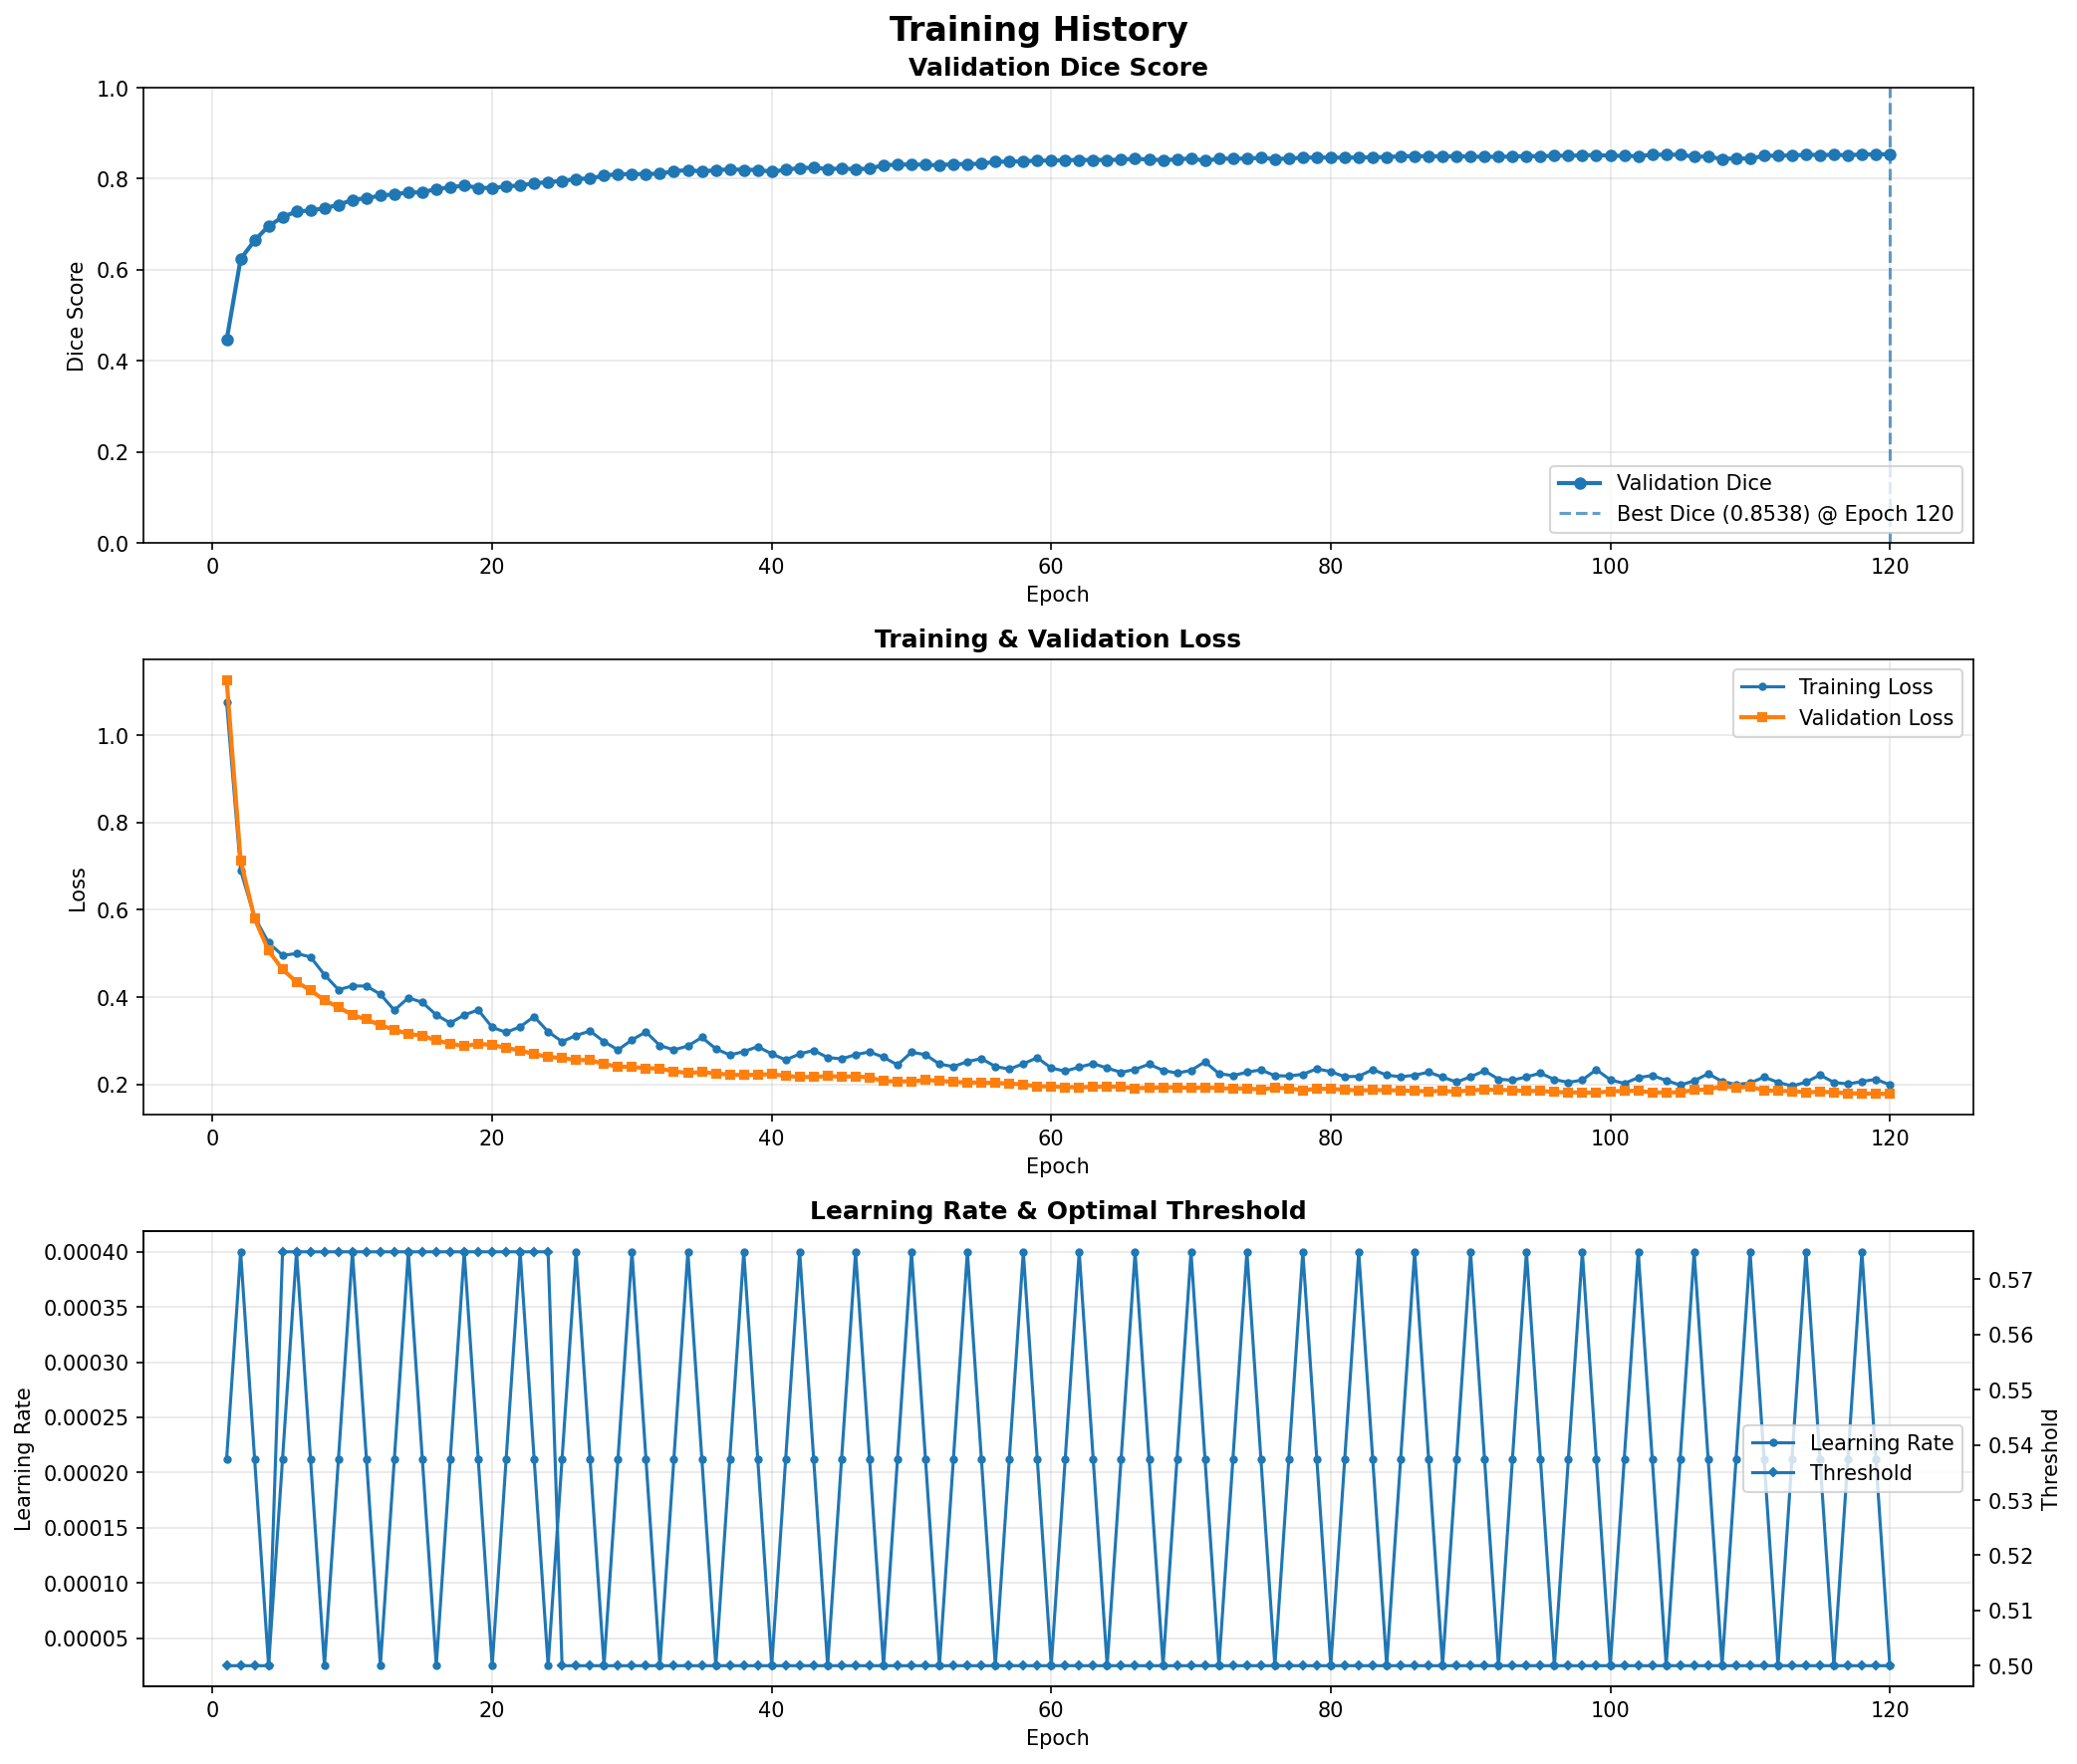

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Final Dice: 0.8538 | Final IoU: 0.7462


In [9]:
history = {
    "epoch": [], "train_loss": [], "val_loss": [], "val_loss_dice": [],
    "val_loss_ce": [], "dice": [], "iou": [], "lr": [], "thr": [], "validated": []
}

print("Starting Training...")

best_metric = -1.0
best_epoch = -1
epochs_no_improve = 0
current_thr = float(CONFIG["init_threshold"])

def get_curriculum(epoch):
    for stage in reversed(CONFIG["curriculum_stages"]):
        if epoch >= stage["epoch_start"]:
            return stage
    return CONFIG["curriculum_stages"][0]

for epoch in range(CONFIG["epochs"]):
    curr_stage = get_curriculum(epoch)
    if epoch == curr_stage["epoch_start"]:
        train_dataset.transform = rand_transform(curr_stage["pos"], curr_stage["neg"])
        print(f"\n[Curriculum] Epoch {epoch+1}: {curr_stage['desc']} (pos={curr_stage['pos']}, neg={curr_stage['neg']})")

    model.train()
    train_loss_sum = 0.0
    train_batches = 0

    if epoch == 0 and torch.cuda.is_available():
        print(f"[Memory] Before training: {torch.cuda.memory_allocated()/1e9:.2f} GB allocated")

    pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=False)
    optimizer.zero_grad(set_to_none=True)

    for batch_idx, batch in enumerate(pbar_train, 1):
        x = batch["image"].to(device, non_blocking=True).float()
        y = batch["label"].to(device, non_blocking=True).float()
        try:
            x = x.to(memory_format=torch.channels_last_3d)
            y = y.to(memory_format=torch.channels_last_3d)
        except Exception:
            pass

        if not (torch.isfinite(x).all() and torch.isfinite(y).all()):
            print(f"[Warning] Skipping batch {batch_idx} - non-finite values")
            continue

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = criterion(logits, y)

        if not torch.isfinite(loss):
            print(f"[Warning] Skipping batch {batch_idx} - NaN/Inf loss")
            continue

        loss_scaled = loss / CONFIG["accum_steps"]
        scaler.scale(loss_scaled).backward()

        if batch_idx % CONFIG["accum_steps"] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, error_if_nonfinite=False)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            ema.update(model)
            scheduler.step()

        train_loss_sum += float(loss.detach())
        train_batches += 1
        pbar_train.set_postfix({"loss": f"{float(loss):.4f}"})

    if (batch_idx % CONFIG["accum_steps"]) != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, error_if_nonfinite=False)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        ema.update(model)
        scheduler.step()

    avg_train_loss = train_loss_sum / max(train_batches, 1)

    do_validate = (epoch + 1) % CONFIG["val_every"] == 0
    if do_validate:
        ema.apply(model)
        do_sweep = (epoch + 1) % CONFIG["thr_sweep_every"] == 0
        calc_components = epoch > CONFIG["epochs"] - 20

        try:
            vloss, vloss_dice, vloss_ce, vdice, viou, best_thr, best_dice_sweep = validate_model(
                model,
                val_loader,
                threshold=current_thr,
                do_threshold_sweep=do_sweep,
                calc_components=calc_components,
            )
        except torch.cuda.OutOfMemoryError:
            print(f"[OOM] Validation failed at epoch {epoch+1}, skipping...")
            torch.cuda.empty_cache()
            vloss, vloss_dice, vloss_ce, vdice, viou, best_thr, best_dice_sweep = (
                float("nan"), float("nan"), float("nan"), 0.0, 0.0, None, None
            )

        ema.restore(model)

        threshold_changed = ""
        if best_thr is not None and best_dice_sweep is not None and (best_dice_sweep - vdice) > 1e-3:
            old_thr = current_thr
            current_thr = float(best_thr)
            threshold_changed = f" | thr {old_thr:.3f}→{current_thr:.3f}"

        is_best = vdice > best_metric + CONFIG["min_delta"]
        if is_best:
            best_metric = vdice
            best_epoch = epoch + 1
            ema.apply(model)
            torch.save(model.state_dict(), CONFIG["best_model_path"])
            ema.restore(model)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(
            f"[Epoch {epoch+1:03d}] "
            f"TrainLoss: {avg_train_loss:.4f} | "
            f"ValLoss: {vloss:.4f} | "
            f"ValDice@thr{current_thr:.2f}: {vdice:.4f} | "
            f"ValIoU: {viou:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.2e}{threshold_changed} "
            f"{'| **NEW BEST**' if is_best else ''}"
        )

        if calc_components and not np.isnan(vloss_dice):
            print(f"          └─ Loss Components - Dice: {vloss_dice:.4f}, CE: {vloss_ce:.4f}")

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(vloss)
        history["val_loss_dice"].append(vloss_dice)
        history["val_loss_ce"].append(vloss_ce)
        history["dice"].append(vdice)
        history["iou"].append(viou)
        history["lr"].append(optimizer.param_groups[0]["lr"])
        history["thr"].append(current_thr)
        history["validated"].append(True)

    else:
        print(f"[Epoch {epoch+1:03d}] TrainLoss: {avg_train_loss:.4f} | Validation: Skipped")
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(float("nan"))
        history["val_loss_dice"].append(float("nan"))
        history["val_loss_ce"].append(float("nan"))
        history["dice"].append(float("nan"))
        history["iou"].append(float("nan"))
        history["lr"].append(optimizer.param_groups[0]["lr"])
        history["thr"].append(current_thr)
        history["validated"].append(False)

    if epochs_no_improve >= CONFIG["patience"]:
        print(f"\n[Early Stopping] No improvement for {CONFIG['patience']} epochs. Best Dice: {best_metric:.4f} @ epoch {best_epoch}")
        break

    if (epoch + 1) % 10 == 0:
        torch.cuda.empty_cache()

print("\nTraining Complete!")
print(f"Best Validation Dice: {best_metric:.4f} @ Epoch {best_epoch}")
print(f"Best Model Saved: {CONFIG['best_model_path']}")
print(f"Final Threshold: {current_thr:.3f}\n")


# PLOTS + FINAL EVAL
 
print("Generating plots...")
epochs = history["epoch"]
val_epochs = [e for e, v in zip(epochs, history["validated"]) if v]

fig, axes = plt.subplots(3, 1, figsize=(14, 12), dpi=150)
fig.suptitle("Training History", fontsize=16, fontweight="bold")

# dice
ax = axes[0]
ax.plot(val_epochs, [history["dice"][i-1] for i in val_epochs], "o-", linewidth=2, markersize=5, label="Validation Dice")
if best_epoch != -1:
    ax.axvline(x=best_epoch, linestyle="--", alpha=0.7, label=f"Best Dice ({best_metric:.4f}) @ Epoch {best_epoch}")
ax.set_title("Validation Dice Score", fontsize=12, fontweight="bold")
ax.set_xlabel("Epoch")
ax.set_ylabel("Dice Score")
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right")
ax.set_ylim(0, 1)

# losses
ax = axes[1]
ax.plot(epochs, history["train_loss"], "o-", linewidth=1.5, markersize=3, label="Training Loss")
ax.plot(val_epochs, [history["val_loss"][i-1] for i in val_epochs], "s-", linewidth=2, markersize=4, label="Validation Loss")
ax.set_title("Training & Validation Loss", fontsize=12, fontweight="bold")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.grid(True, alpha=0.3)
ax.legend()

# lr + thr
ax = axes[2]
ax_twin = ax.twinx()
line1 = ax.plot(epochs, history["lr"], "o-", linewidth=1.5, markersize=3, label="Learning Rate")
line2 = ax_twin.plot(val_epochs, [history["thr"][i-1] for i in val_epochs], "D-", linewidth=1.5, markersize=3, label="Threshold")
ax.set_title("Learning Rate & Optimal Threshold", fontsize=12, fontweight="bold")
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")
ax_twin.set_ylabel("Threshold")
ax.grid(True, alpha=0.3)
lines = line1 + line2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc="center right")

plt.tight_layout()
plt.savefig("training_history.png", dpi=300, bbox_inches="tight")
print("Plot saved: training_history.png")
plt.show()

# load best + final sweep
model.load_state_dict(torch.load(CONFIG["best_model_path"], map_location=device))
final_metrics = validate_model(model, val_loader, threshold=current_thr, do_threshold_sweep=True, calc_components=True)
print(f"Final Dice: {final_metrics[3]:.4f} | Final IoU: {final_metrics[4]:.4f}")